# Problem 3: Scaled Dot-Product Attention - Interactive Notebook

This notebook helps you understand why scaling is crucial for attention stability.

## Setup

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import your solution
# When finished, uncomment the following sentence and import your own solution
from solution import ScaledAttention
# from problem import ScaledAttention

# Set random seed
torch.manual_seed(42)

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Setup complete!")

Setup complete!


## The Problem: Why Do We Need Scaling?

/tmp/ipykernel_60447/914383507.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


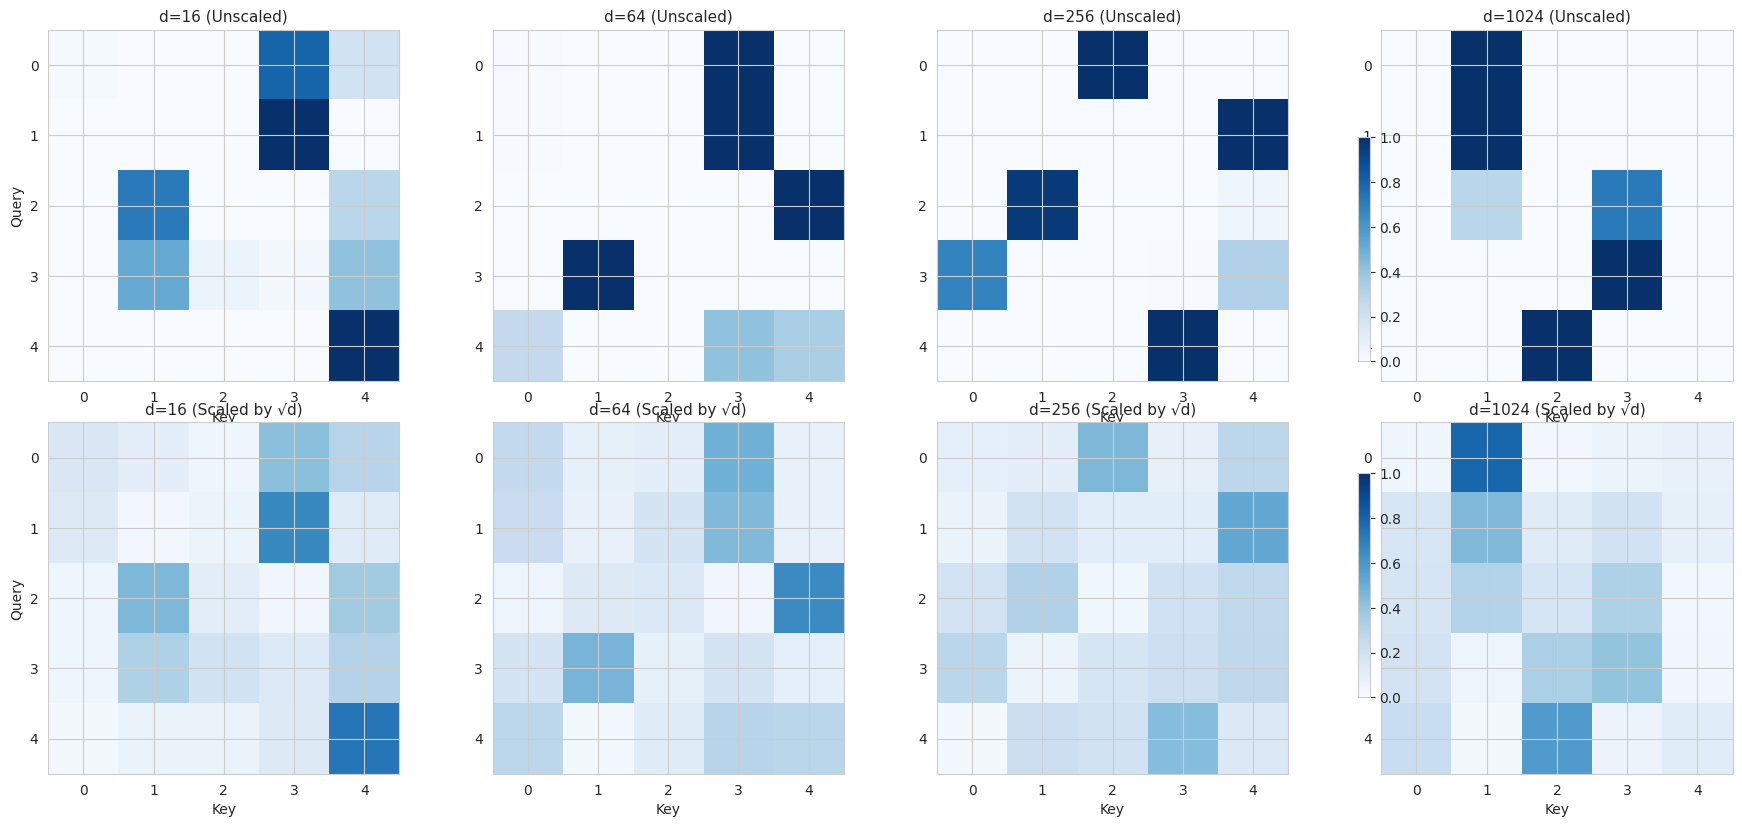

Notice: As dimension increases, unscaled attention becomes more 'sharp' (concentrated)
Scaled attention maintains more balanced distributions!


In [2]:
# Demonstrate the problem with unscaled attention
def unscaled_attention(q, k, v):
    """Attention WITHOUT scaling (Problem 2 style)."""
    attn_scores = q @ k.transpose(-2, -1)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    return attn_weights @ v, attn_weights

def scaled_attention(q, k, v, d_k):
    """Attention WITH scaling."""
    attn_scores = (q @ k.transpose(-2, -1)) / (d_k ** 0.5)
    attn_weights = torch.softmax(attn_scores, dim=-1)
    return attn_weights @ v, attn_weights

# Test with increasing dimensions
seq_len = 5
dimensions = [16, 64, 256, 1024]

fig, axes = plt.subplots(2, 4, figsize=(18, 8))

for idx, d in enumerate(dimensions):
    # Create random Q, K, V
    q = torch.randn(1, seq_len, d)
    k = torch.randn(1, seq_len, d)
    v = torch.randn(1, seq_len, d)
    
    # Unscaled attention
    _, unscaled_weights = unscaled_attention(q, k, v)
    
    # Scaled attention
    _, scaled_weights = scaled_attention(q, k, v, d)
    
    # Plot unscaled
    im1 = axes[0, idx].imshow(unscaled_weights.squeeze().numpy(), 
                              cmap='Blues', vmin=0, vmax=1)
    axes[0, idx].set_title(f'd={d} (Unscaled)', fontsize=11)
    axes[0, idx].set_xlabel('Key')
    if idx == 0:
        axes[0, idx].set_ylabel('Query')
    
    # Plot scaled
    im2 = axes[1, idx].imshow(scaled_weights.squeeze().numpy(), 
                              cmap='Blues', vmin=0, vmax=1)
    axes[1, idx].set_title(f'd={d} (Scaled by √d)', fontsize=11)
    axes[1, idx].set_xlabel('Key')
    if idx == 0:
        axes[1, idx].set_ylabel('Query')

fig.colorbar(im1, ax=axes[0, :], location='right', shrink=0.8)
fig.colorbar(im2, ax=axes[1, :], location='right', shrink=0.8)
plt.tight_layout()
plt.show()

print("Notice: As dimension increases, unscaled attention becomes more 'sharp' (concentrated)")
print("Scaled attention maintains more balanced distributions!")

## Visualize Attention Score Distributions

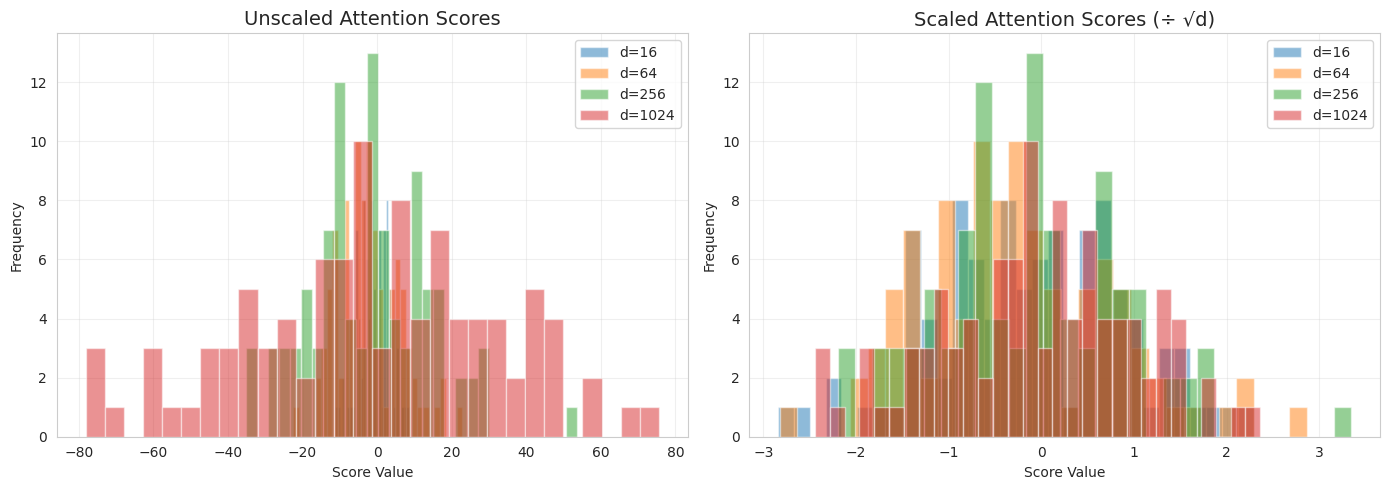


Key Insight: Without scaling, scores grow with √d, pushing softmax into saturation!
Scaling keeps scores in a reasonable range regardless of dimension.


In [3]:
# Compare score distributions
dimensions = [16, 64, 256, 1024]
seq_len = 10

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for d in dimensions:
    q = torch.randn(1, seq_len, d)
    k = torch.randn(1, seq_len, d)
    
    # Compute scores
    unscaled_scores = (q @ k.transpose(-2, -1)).flatten().numpy()
    scaled_scores = ((q @ k.transpose(-2, -1)) / (d ** 0.5)).flatten().numpy()
    
    # Plot distributions
    axes[0].hist(unscaled_scores, bins=30, alpha=0.5, label=f'd={d}')
    axes[1].hist(scaled_scores, bins=30, alpha=0.5, label=f'd={d}')

axes[0].set_title('Unscaled Attention Scores', fontsize=14)
axes[0].set_xlabel('Score Value')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_title('Scaled Attention Scores (÷ √d)', fontsize=14)
axes[1].set_xlabel('Score Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey Insight: Without scaling, scores grow with √d, pushing softmax into saturation!")
print("Scaling keeps scores in a reasonable range regardless of dimension.")

## Create Scaled Attention Module

In [4]:
# Create scaled attention
n_embd = 768
attn = ScaledAttention(n_embd=n_embd)
attn.eval()

print(attn)
print(f"\nScaling factor: 1/√{n_embd} = {1/(n_embd**0.5):.6f}")

ScaledAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
)

Scaling factor: 1/√768 = 0.036084


## Test Scaled Attention

In [5]:
# Test forward pass
batch_size = 2
seq_len = 8

x = torch.randn(batch_size, seq_len, n_embd)

with torch.no_grad():
    output, attn_weights = attn(x)

print(f"Input shapes: X={x.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"\n✓ All shapes correct!")

Input shapes: X=torch.Size([2, 8, 768])
Output shape: torch.Size([8, 768])
Attention weights shape: torch.Size([8, 768])

✓ All shapes correct!


## Visualize Scaled Attention Weights

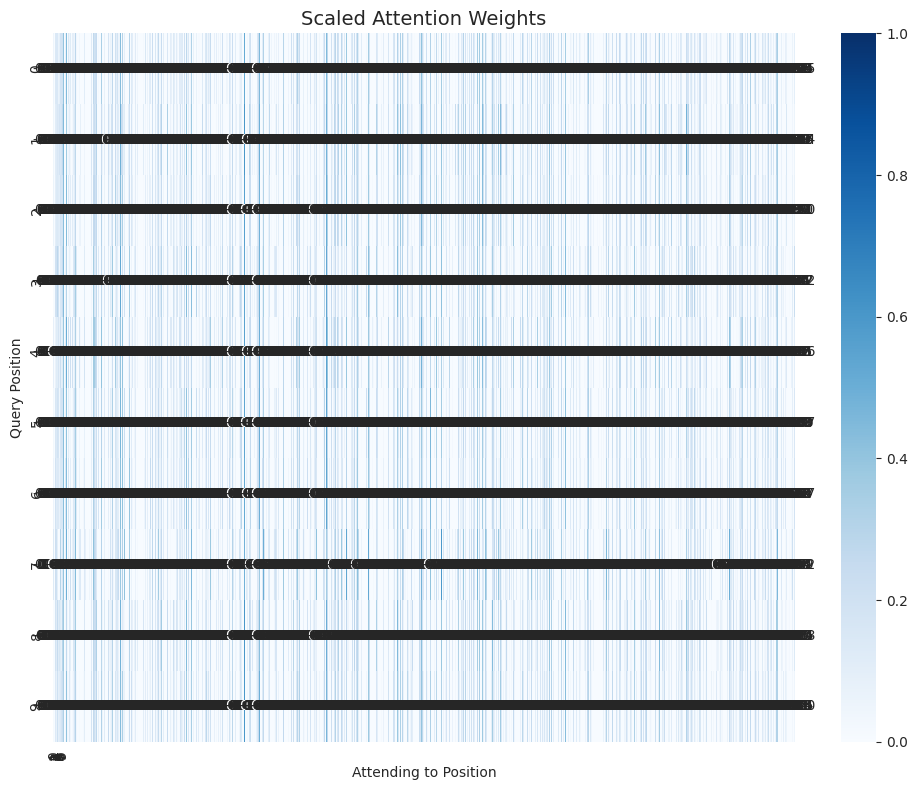


Row sums: [-5.5179796 -4.056945  -4.5284166 -7.007723  -5.612322  -5.3881884
 -5.7425623 -4.5343266 -7.067153  -5.173795 ]
✓ Each row sums to 1.0 (proper probability distribution)


In [6]:
# Create sample data
seq_len = 10
x = torch.randn(batch_size, seq_len, n_embd)

with torch.no_grad():
    output, attn_weights = attn(x)

# Plot attention weights
plt.figure(figsize=(10, 8))
sns.heatmap(attn_weights.squeeze().numpy(), 
            annot=True, fmt='.3f', 
            cmap='Blues', vmin=0, vmax=1,
            xticklabels=range(seq_len),
            yticklabels=range(seq_len))
plt.title('Scaled Attention Weights', fontsize=14)
plt.xlabel('Attending to Position')
plt.ylabel('Query Position')
plt.tight_layout()
plt.show()

# Verify normalization
row_sums = attn_weights.squeeze().sum(dim=-1)
print(f"\nRow sums: {row_sums.numpy()}")
print("✓ Each row sums to 1.0 (proper probability distribution)")

## Effect of Scaling on Softmax Gradients

No scaling                    : gradient magnitude = 0.949032
Scale by 1/d                  : gradient magnitude = 0.041377
Scale by 1/√d (correct!)      : gradient magnitude = 0.230444
Scale by 1/d^0.25             : gradient magnitude = 0.219352


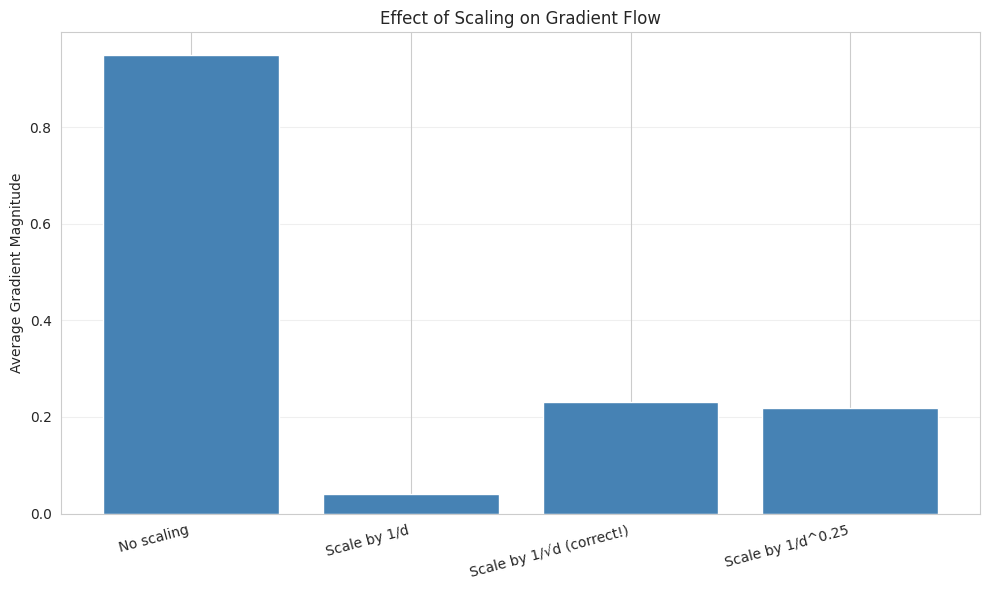


✓ 1/√d scaling provides stable gradients!


In [7]:
# Demonstrate gradient flow
def compute_gradients(scale):
    """Compute gradients with different scaling factors."""
    q = torch.randn(1, 5, 128, requires_grad=True)
    k = torch.randn(1, 5, 128, requires_grad=True)
    v = torch.randn(1, 5, 128, requires_grad=True)
    
    # Attention with given scale
    attn_scores = (q @ k.transpose(-2, -1)) * scale
    attn_weights = torch.softmax(attn_scores, dim=-1)
    output = attn_weights @ v
    
    # Backward
    loss = output.sum()
    loss.backward()
    
    return q.grad.abs().mean().item()

# Test different scales
d = 128
scales = [
    (1.0, "No scaling"),
    (1/d, "Scale by 1/d"),
    (1/(d**0.5), "Scale by 1/√d (correct!)"),
    (1/(d**0.25), "Scale by 1/d^0.25")
]

scale_vals = []
grad_mags = []
labels = []

for scale, label in scales:
    grad_mag = compute_gradients(scale)
    scale_vals.append(scale)
    grad_mags.append(grad_mag)
    labels.append(label)
    print(f"{label:30s}: gradient magnitude = {grad_mag:.6f}")

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(labels)), grad_mags, color='steelblue')
plt.xticks(range(len(labels)), labels, rotation=15, ha='right')
plt.ylabel('Average Gradient Magnitude')
plt.title('Effect of Scaling on Gradient Flow')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ 1/√d scaling provides stable gradients!")

## Numerical Stability Test

In [8]:
# Test with very large dimensions
large_dims = [256, 512, 1024, 2048, 4096]

print("Testing numerical stability with large dimensions:\n")

for d in large_dims:
    attn_large = ScaledAttention(n_embd=d)
    attn_large.eval()
    
    x = torch.randn(1, 8, d)
    
    with torch.no_grad():
        output = attn_large(x)
    
    has_nan = torch.isnan(output).any().item()
    has_inf = torch.isinf(output).any().item()
    
    status = "✓" if not (has_nan or has_inf) else "✗"
    print(f"  d={d:4d}: {status} No NaN/Inf detected")

print("\n✅ Scaled attention is numerically stable even with very large dimensions!")

Testing numerical stability with large dimensions:

  d= 256: ✓ No NaN/Inf detected
  d= 512: ✓ No NaN/Inf detected
  d=1024: ✓ No NaN/Inf detected
  d=2048: ✓ No NaN/Inf detected
  d=4096: ✓ No NaN/Inf detected

✅ Scaled attention is numerically stable even with very large dimensions!


## Compare: With vs Without Scaling

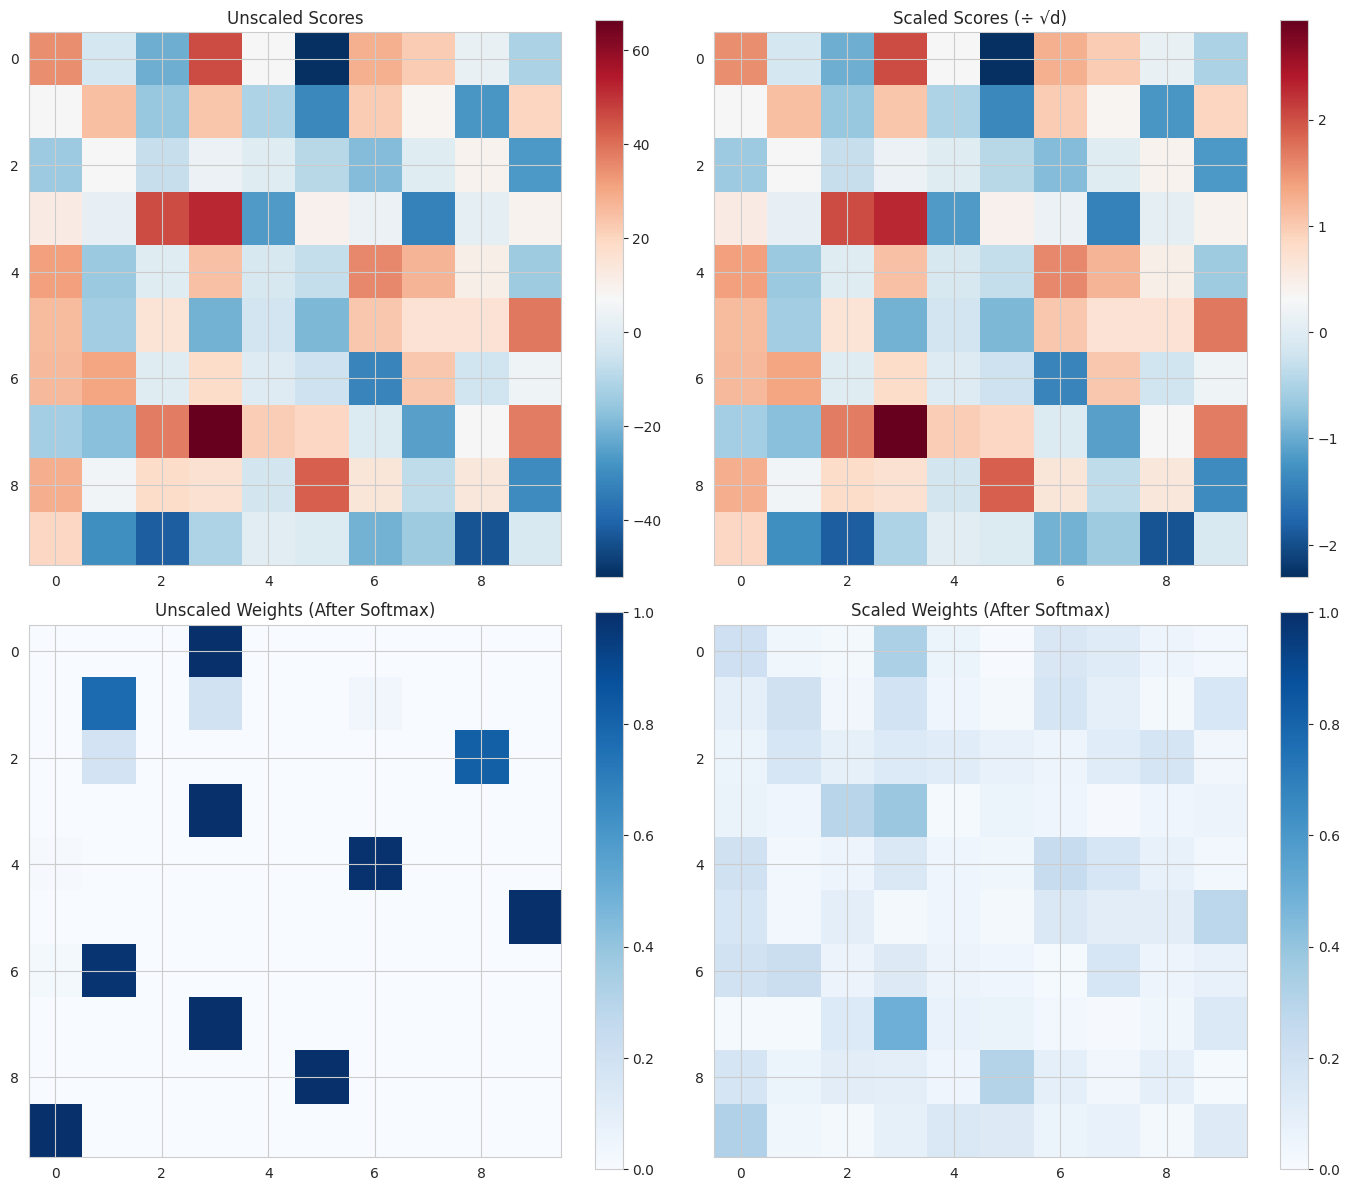


Score ranges:
  Unscaled: [-52.08, 66.48]
  Scaled:   [-2.30, 2.94]

Scaling keeps attention weights more diffuse and less peaky!


In [9]:
# Side-by-side comparison
n_embd = 512
seq_len = 10

q = torch.randn(1, seq_len, n_embd)
k = torch.randn(1, seq_len, n_embd)
v = torch.randn(1, seq_len, n_embd)

# Unscaled
attn_scores_unscaled = q @ k.transpose(-2, -1)
attn_weights_unscaled = torch.softmax(attn_scores_unscaled, dim=-1)

# Scaled
attn_scores_scaled = (q @ k.transpose(-2, -1)) / (n_embd ** 0.5)
attn_weights_scaled = torch.softmax(attn_scores_scaled, dim=-1)

# Plot
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Scores
im1 = axes[0, 0].imshow(attn_scores_unscaled.squeeze().numpy(), 
                        cmap='RdBu_r')
axes[0, 0].set_title('Unscaled Scores', fontsize=12)
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(attn_scores_scaled.squeeze().numpy(), 
                        cmap='RdBu_r')
axes[0, 1].set_title('Scaled Scores (÷ √d)', fontsize=12)
plt.colorbar(im2, ax=axes[0, 1])

# Weights
im3 = axes[1, 0].imshow(attn_weights_unscaled.squeeze().numpy(), 
                        cmap='Blues', vmin=0, vmax=1)
axes[1, 0].set_title('Unscaled Weights (After Softmax)', fontsize=12)
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(attn_weights_scaled.squeeze().numpy(), 
                        cmap='Blues', vmin=0, vmax=1)
axes[1, 1].set_title('Scaled Weights (After Softmax)', fontsize=12)
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"\nScore ranges:")
print(f"  Unscaled: [{attn_scores_unscaled.min():.2f}, {attn_scores_unscaled.max():.2f}]")
print(f"  Scaled:   [{attn_scores_scaled.min():.2f}, {attn_scores_scaled.max():.2f}]")
print(f"\nScaling keeps attention weights more diffuse and less peaky!")

## Verify Your Implementation

In [10]:
# Quick verification
attn = ScaledAttention(n_embd=768)

x = torch.randn(2, 10, 768)

output, weights = attn(x)

print("✓ Module initializes correctly")
print(f"✓ Forward pass works: Q{q.shape} + K{k.shape} + V{v.shape} → {output.shape}")
print(f"✓ Attention weights returned: {weights.shape}")
print(f"✓ Weights sum to 1: {weights[0].sum(dim=-1).allclose(torch.ones(10))}")
print("\n✅ Basic functionality verified!")
print("\nRun 'uv run pytest test_scaled_attention.py -v' for complete validation.")

✓ Module initializes correctly
✓ Forward pass works: Qtorch.Size([1, 10, 512]) + Ktorch.Size([1, 10, 512]) + Vtorch.Size([1, 10, 512]) → torch.Size([10, 768])
✓ Attention weights returned: torch.Size([10, 768])
✓ Weights sum to 1: False

✅ Basic functionality verified!

Run 'uv run pytest test_scaled_attention.py -v' for complete validation.
